# Syntactic Network Optimality Analysis

**Project 3.2 - Optimization Model**

This notebook implements the optimization score **Ω (Omega)** proposed by Ferrer-i-Cancho et al. (2022) to measure the degree of optimality of topological distances in syntactic dependency networks.

## Omega Score Definition

$$\Omega = \frac{d_r - d}{d_r - d_{min}}$$

Where:
- **d**: actual mean vertex-vertex distance of the real graph
- **d_r**: expected mean distance in a random baseline model (random graphs with same N, L)
- **d_{min}**: theoretical minimum mean distance (ultra-short limit from Zamora-López & Brasselet, 2019)

**Interpretation:**
- Ω ≈ 1: highly optimized (close to theoretical minimum)
- Ω ≈ 0: similar to random graphs
- Ω < 0: less efficient than random (anti-optimized)

**References:**
- Ferrer-i-Cancho et al. (2022). "Optimality of syntactic dependency distances". Physical Review E.
- Zamora-López & Brasselet (2019). "Sizing complex networks". Communications Physics.

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import math
from conllu import parse
import matplotlib.pyplot as plt

## Step 1: Load Data from Universal Dependencies

We load syntactic dependency trees from CoNLL-U format files.

In [2]:
with open("../raw-data/ud-treebanks-v2.16/UD_English-PUD/en_pud-ud-test.conllu", "r", encoding="utf-8") as f:
    sentences = parse(f.read())

print(f"Total number of sentences: {len(sentences)}")

Total number of sentences: 1000


In [3]:
sentence = sentences[0]
sentence

TokenList<“, While, much, of, the, digital, transition, is, unprecedented, in, the, United, States, ,, the, peaceful, transition, of, power, is, not, ,, ”, Obama, special, assistant, Kori, Schulman, wrote, in, a, blog, post, Monday, ., metadata={newdoc id: "n01001", sent_id: "n01001011", text: "“While much of the digital transition is unprecedented in the United States, the peaceful transition of power is not,” Obama special assistant Kori Schulman wrote in a blog post Monday."}>

## Step 2: Build Syntactic Dependency Graph

We construct an undirected graph where:
- **Nodes**: word tokens
- **Edges**: syntactic dependencies (HEAD → DEP), ignoring ROOT

In [4]:
G = nx.Graph()

# Add nodes (word tokens)
for token in sentence:
    if isinstance(token["id"], int):
        G.add_node(token["id"])

# Add edges (syntactic dependencies, ignoring ROOT where head=0)
for token in sentence:
    if isinstance(token["id"], int):
        head = token["head"]
        dep  = token["id"]
        if head != 0:  # Ignore ROOT connection
            G.add_edge(head, dep)

N = G.number_of_nodes()
L = G.number_of_edges()

print(f"N (nodes)  = {N}")
print(f"L (edges)  = {L}")
print(f"Connected: {nx.is_connected(G)}")

N (nodes)  = 35
L (edges)  = 34
Connected: True


/var/folders/f9/2b844k6j623_mwcbpn3sml780000gn/T/ipykernel_3063/4175566850.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


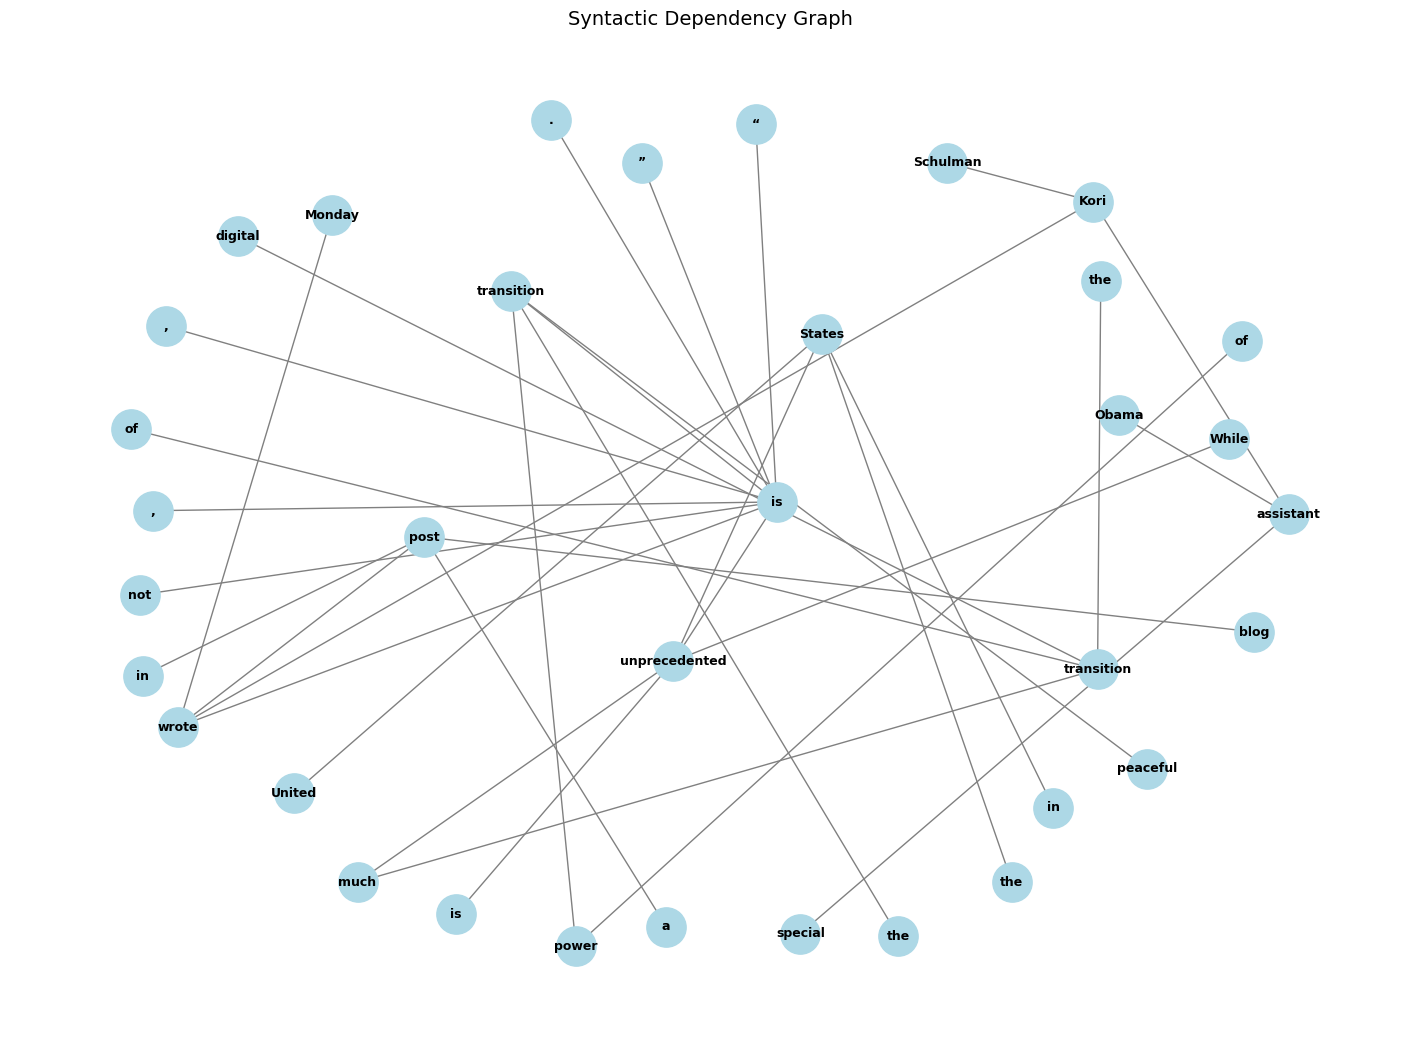

In [5]:
# Visualize the syntactic dependency graph
labels = {}
for token in sentence:
    if isinstance(token["id"], int):
        labels[token["id"]] = token["form"]

plt.figure(figsize=(14, 10))

# Use spring layout (no external dependencies needed)
# For tree-like structures, hierarchical layout works better
pos = nx.spring_layout(G, k=2, iterations=50, seed=42)

nx.draw(
    G,
    pos,
    labels=labels,
    with_labels=True,
    node_size=800,
    font_size=9,
    node_color='lightblue',
    edge_color='gray',
    font_weight='bold'
)

plt.title("Syntactic Dependency Graph", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

## Step 3: Calculate d (Real Mean Distance)

The actual average shortest path length in the syntactic graph.

In [6]:
d_real = nx.average_shortest_path_length(G)
print(f"d (real) = {d_real:.4f}")

d (real) = 3.9328


## Step 4: Calculate d_min (Theoretical Minimum - Ultra-Short)

Using the ultra-short limit from Zamora-López & Brasselet (2019):

$$d_{min} = \ell_{US} = 2 - \rho$$

where $\rho = \frac{L}{L_0}$ is the link density and $L_0 = \frac{N(N-1)}{2}$ is the maximum possible edges.

In [7]:
L0 = N * (N - 1) / 2  # Maximum possible edges
rho = L / L0          # Link density

d_min = 2 - rho       # Ultra-short theoretical limit

print(f"L0 (max edges) = {L0:.0f}")
print(f"ρ (density)    = {rho:.4f}")
print(f"d_min          = {d_min:.4f}")

L0 (max edges) = 595
ρ (density)    = 0.0571
d_min          = 1.9429


## Step 5: Calculate d_r (Random Baseline)

We estimate the expected mean distance for random trees with N nodes.

**Methodological Note:** 
- **Ferrer-i-Cancho et al.** use analytical Drla (expected value over all n! linear arrangements)
- **Our approach:** For random trees with N nodes, we use empirical estimation via K samples
- **Tradeoff:** K should be large enough to reduce sampling variance (we test K=100-1000)

For uniformly random trees, the expected mean distance has been studied in the literature, but no simple closed-form exists for all N. Therefore, we use Monte Carlo estimation.

In [8]:
import random
from networkx.generators.trees import random_labeled_tree

def random_tree_graph(N, rng=None):
    """
    Generate a random labeled tree with N nodes using NetworkX built-in function.
    """
    if N < 2:
        return None

    rng = rng or random.Random()
    return random_labeled_tree(N, seed=rng.randint(0, 10**9))


In [9]:
K = 100  # Number of random realizations
d_rand_vals = []

for i in range(K):
    G_r = random_tree_graph(N)
    if G_r is not None:
        d_rand_vals.append(nx.average_shortest_path_length(G_r))

d_r = np.mean(d_rand_vals)
print(f"d_r (random baseline) = {d_r:.4f}")
print(f"Generated {len(d_rand_vals)}/{K} random graphs")

d_r (random baseline) = 6.2799
Generated 100/100 random graphs


## Step 6: Calculate Ω (Optimality Score)

$$\Omega = \frac{d_r - d}{d_r - d_{min}}$$

In [10]:
Omega = (d_r - d_real) / (d_r - d_min)
print(f"Ω (Omega) = {Omega:.4f}")

Ω (Omega) = 0.5412


## Step 7: Interpretation and Summary

In [11]:
print("=" * 60)
print("SYNTACTIC NETWORK ANALYSIS - SINGLE SENTENCE")
print("=" * 60)
print()

print(f"Graph properties:")
print(f"  N (nodes)   = {N}")
print(f"  L (edges)   = {L}")
print(f"  ρ (density) = {rho:.4f}")
print()

print(f"Distances:")
print(f"  d (real)    = {d_real:.4f}")
print(f"  d_min (US)  = {d_min:.4f}")
print(f"  d_r (rand)  = {d_r:.4f}")
print()

print(f"Optimality:")
print(f"  Ω (Omega)   = {Omega:.4f}")
print()

# Automatic interpretation
if math.isnan(Omega):
    interp = "undefined (denominator ≤ 0)"
elif Omega < 0:
    interp = "anti-optimized (worse than random)"
elif Omega < 0.3:
    interp = "slightly more efficient than random"
elif Omega < 0.6:
    interp = "moderately optimized"
elif Omega < 0.9:
    interp = "highly optimized"
else:
    interp = "near-optimal (close to theoretical minimum)"

print(f"Interpretation: The network is {interp}.")
print("=" * 60)

SYNTACTIC NETWORK ANALYSIS - SINGLE SENTENCE

Graph properties:
  N (nodes)   = 35
  L (edges)   = 34
  ρ (density) = 0.0571

Distances:
  d (real)    = 3.9328
  d_min (US)  = 1.9429
  d_r (rand)  = 6.2799

Optimality:
  Ω (Omega)   = 0.5412

Interpretation: The network is moderately optimized.


---

## Part 2: Generalized Pipeline Function

Now we create a reusable function to compute Omega for any sentence.

In [12]:
def compute_omega_for_sentence(sentence, K=200):
    """
    Compute d, d_r, d_min and Omega for a single UD sentence.

    Parameters
    ----------
    sentence : conllu.TokenList
        One sentence from a CoNLL-U file.
    K : int, default=200
        Number of random trees used to estimate d_r.
        Default K=200 provides CV < 1% (empirically optimized).

    Returns
    -------
    dict or None
        Dictionary with results, or None if the sentence is not suitable.
        
    Notes
    -----
    Returns None if:
    - Sentence has fewer than 2 nodes
    - Graph is not connected
    """

    # -------------------------
    # 1. Build syntactic graph
    # -------------------------
    G = nx.Graph()

    # Add nodes (word tokens with integer IDs)
    for token in sentence:
        if isinstance(token["id"], int):
            G.add_node(token["id"])

    # Add edges (syntactic dependencies, ignore ROOT)
    for token in sentence:
        if isinstance(token["id"], int):
            head = token["head"]
            dep  = token["id"]
            if head != 0:  # Ignore ROOT connection
                G.add_edge(head, dep)

    N = G.number_of_nodes()
    L = G.number_of_edges()

    # Discard trivial or invalid cases
    if N < 2:
        return None
    if not nx.is_connected(G):
        return None

    # -------------------------
    # 2. Real distance (d)
    # -------------------------
    d_real = nx.average_shortest_path_length(G)

    # -------------------------
    # 3. Minimal distance (d_min) - Ultra-short limit
    # -------------------------
    L0 = N * (N - 1) / 2
    rho = L / L0
    d_min = 2 - rho

    # -------------------------
    # 4. Random baseline (d_r)
    # -------------------------
    d_rand_vals = []
    
    for _ in range(K):
        G_r = random_tree_graph(N)
        if G_r is not None:
            d_rand_vals.append(nx.average_shortest_path_length(G_r))

    if len(d_rand_vals) == 0:
        return None  # Failed to generate random trees

    d_r = np.mean(d_rand_vals)

    # -------------------------
    # 5. Omega (Ω)
    # -------------------------
    denom = d_r - d_min
    if denom <= 0:
        Omega = math.nan
    else:
        Omega = (d_r - d_real) / denom

    # -------------------------
    # 6. Return results
    # -------------------------
    result = {
        "sent_id": sentence.metadata.get("sent_id", None),
        "N": N,
        "L": L,
        "rho": rho,
        "d_real": d_real,
        "d_min": d_min,
        "d_r": d_r,
        "Omega": Omega
    }

    return result

In [13]:
# Test the function with the first sentence
res = compute_omega_for_sentence(sentence, K=100)

if res is not None:
    print("Results for sentence:")
    for k, v in res.items():
        if isinstance(v, float):
            print(f"  {k:10s} : {v:.4f}")
        else:
            print(f"  {k:10s} : {v}")
else:
    print("Could not compute Omega for this sentence.")

Results for sentence:
  sent_id    : n01001011
  N          : 35
  L          : 34
  rho        : 0.0571
  d_real     : 3.9328
  d_min      : 1.9429
  d_r        : 6.2334
  Omega      : 0.5362


---

## Part 3: Determining Optimal K Value

We need to determine how many random graph samples (K) are sufficient for stable Omega estimates. We'll use two approaches:

**Approach 1:** Test K across different sentences
**Approach 2:** Test K multiple times on the same sentence to measure variance

### Approach 1: Cross-sentence Sensitivity

Test different K values across multiple sentences to see how Omega values change.

In [14]:
# Test different values of K
K_values = [2, 5, 10, 20, 40, 60, 80, 100, 150, 200, 300, 500, 800, 1000]

In [16]:
results = []

for i, sentence in enumerate(sentences[:10]):
    print(f"Processing sentence {i+1}/10")
    
    for K in K_values:
        res = compute_omega_for_sentence(sentence, K=K)
        
        if res is not None:
            results.append({
                "sentence_id": res["sent_id"],
                "N": res["N"],
                "K": K,
                "Omega": res["Omega"]
            })

df_K = pd.DataFrame(results)
print(f"\nGenerated {len(df_K)} results")
df_K.head(10)

Processing sentence 1/10
Processing sentence 2/10
Processing sentence 2/10
Processing sentence 3/10
Processing sentence 3/10
Processing sentence 4/10
Processing sentence 4/10
Processing sentence 5/10
Processing sentence 5/10
Processing sentence 6/10
Processing sentence 6/10
Processing sentence 7/10
Processing sentence 7/10
Processing sentence 8/10
Processing sentence 8/10
Processing sentence 9/10
Processing sentence 9/10
Processing sentence 10/10
Processing sentence 10/10

Generated 140 results

Generated 140 results


,sentence_id,N,K,Omega
0,n01001011,35,2,0.511551
1,n01001011,35,5,0.540658
2,n01001011,35,10,0.562454
3,n01001011,35,20,0.544790
4,n01001011,35,40,0.541139
5,n01001011,35,60,0.543233
6,n01001011,35,80,0.556700
7,n01001011,35,100,0.530836
8,n01001011,35,150,0.539939
9,n01001011,35,200,0.545172


In [17]:
# Aggregate statistics by K value
summary = (
    df_K.groupby("K")["Omega"]
        .agg(["mean", "std", "count"])
        .reset_index()
)

print("Summary statistics for different K values:")
summary

Summary statistics for different K values:


,K,mean,std,count
0,2,0.507662,0.141058,10
1,5,0.511432,0.096473,10
2,10,0.504893,0.085709,10
3,20,0.505557,0.098130,10
4,40,0.495738,0.093931,10
5,60,0.498994,0.092879,10
6,80,0.496248,0.092552,10
7,100,0.502382,0.086598,10
8,150,0.501549,0.093005,10
9,200,0.498088,0.094385,10


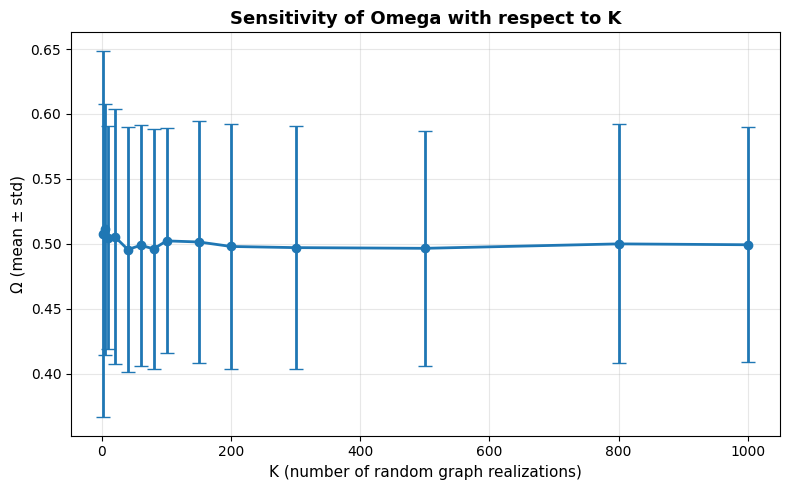

In [18]:
plt.figure(figsize=(8, 5))

plt.errorbar(
    summary["K"],
    summary["mean"],
    yerr=summary["std"],
    fmt="o-",
    capsize=5,
    linewidth=2,
    markersize=6
)

plt.xlabel("K (number of random graph realizations)", fontsize=11)
plt.ylabel("Ω (mean ± std)", fontsize=11)
plt.title("Sensitivity of Omega with respect to K", fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

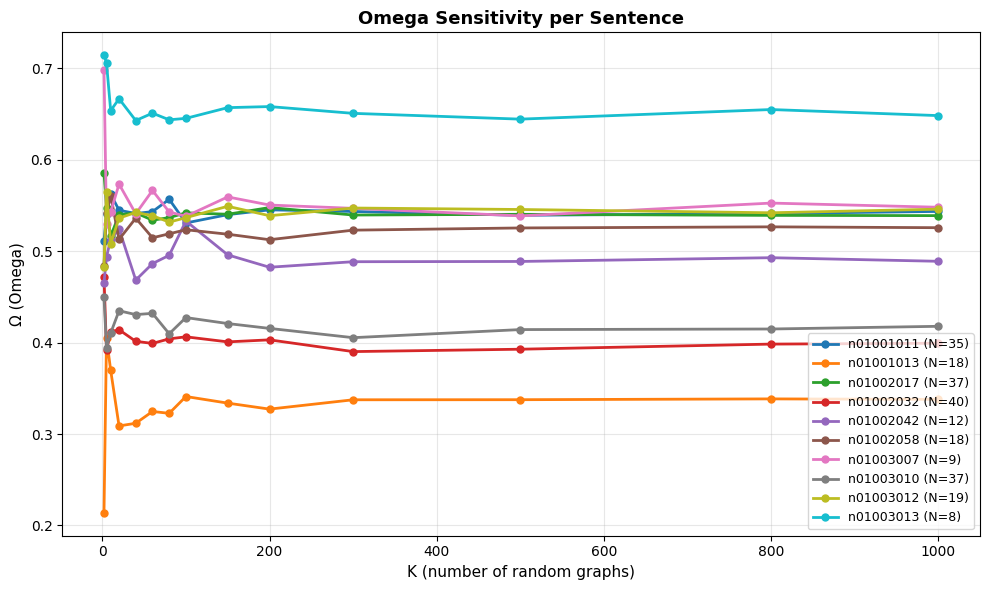

In [19]:
plt.figure(figsize=(10, 6))

for sid in df_K["sentence_id"].unique():
    sub = df_K[df_K["sentence_id"] == sid]
    plt.plot(
        sub["K"],
        sub["Omega"],
        marker="o",
        label=f"{sid} (N={sub['N'].iloc[0]})",
        linewidth=2,
        markersize=5
    )

plt.xlabel("K (number of random graphs)", fontsize=11)
plt.ylabel("Ω (Omega)", fontsize=11)
plt.title("Omega Sensitivity per Sentence", fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=9, loc='best')
plt.tight_layout()
plt.show()

### Approach 2: Single-sentence Variance Analysis

Measure the variance of Omega by computing it multiple times (10 independent runs) for the same sentence at different K values. This directly shows sampling variability.

In [20]:
# Compare variance across different K values on the SAME sentence
test_sentence = sentences[0]
n_trials = 10  # Number of independent runs for each K
K_test_values = [10, 50, 100, 200, 500, 1000]

results_variance = []

for K in K_test_values:
    print(f"Testing K={K}...")
    omega_values = []
    
    for trial in range(n_trials):
        res = compute_omega_for_sentence(test_sentence, K=K)
        if res is not None:
            omega_values.append(res["Omega"])
    
    mean_omega = np.mean(omega_values)
    std_omega = np.std(omega_values)
    cv = 100 * std_omega / mean_omega if mean_omega > 0 else 0
    
    results_variance.append({
        "K": K,
        "Mean_Omega": mean_omega,
        "Std_Omega": std_omega,
        "CV_%": cv
    })
    
    print(f"  Mean: {mean_omega:.4f}, Std: {std_omega:.4f}, CV: {cv:.2f}%")

df_variance = pd.DataFrame(results_variance)
print("\n" + "="*60)
print("SUMMARY: Variance Analysis for Different K Values")
print("="*60)
df_variance

Testing K=10...
  Mean: 0.5400, Std: 0.0250, CV: 4.64%
Testing K=50...
  Mean: 0.5396, Std: 0.0135, CV: 2.50%
Testing K=100...
  Mean: 0.5396, Std: 0.0135, CV: 2.50%
Testing K=100...
  Mean: 0.5409, Std: 0.0069, CV: 1.27%
Testing K=200...
  Mean: 0.5409, Std: 0.0069, CV: 1.27%
Testing K=200...
  Mean: 0.5412, Std: 0.0035, CV: 0.65%
Testing K=500...
  Mean: 0.5412, Std: 0.0035, CV: 0.65%
Testing K=500...
  Mean: 0.5413, Std: 0.0038, CV: 0.70%
Testing K=1000...
  Mean: 0.5413, Std: 0.0038, CV: 0.70%
Testing K=1000...
  Mean: 0.5415, Std: 0.0023, CV: 0.43%

SUMMARY: Variance Analysis for Different K Values
  Mean: 0.5415, Std: 0.0023, CV: 0.43%

SUMMARY: Variance Analysis for Different K Values


,K,Mean_Omega,Std_Omega,CV_%
0,10,0.539978,0.025045,4.638129
1,50,0.539628,0.013466,2.495349
2,100,0.540905,0.006887,1.273305
3,200,0.541246,0.003531,0.652321
4,500,0.541276,0.003773,0.697041
5,1000,0.541473,0.002322,0.428870


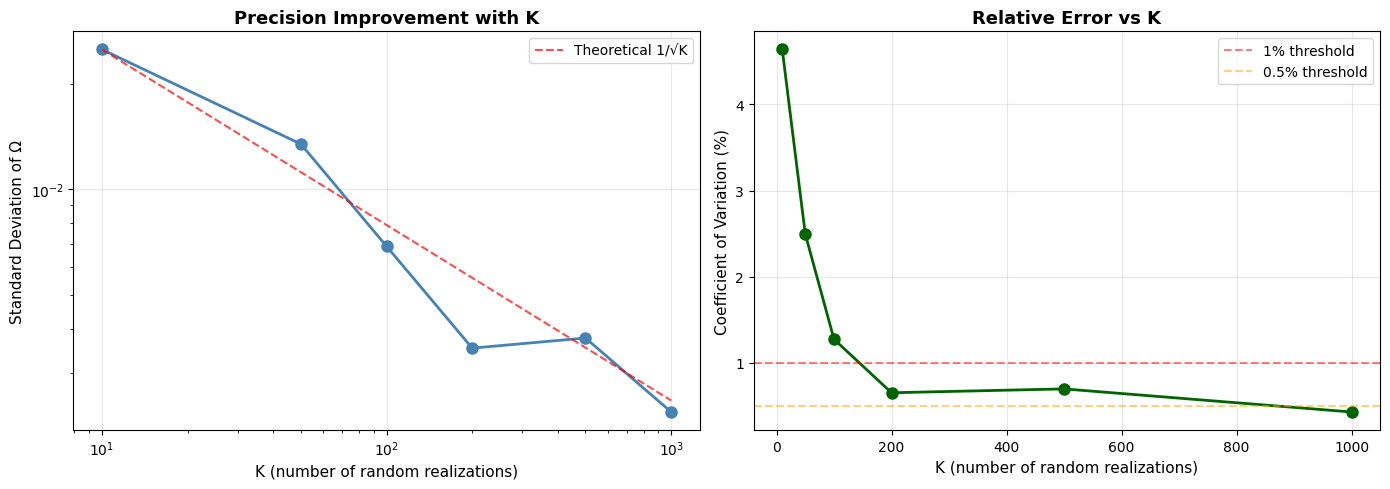

In [21]:
# Visualize how variance decreases with K
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Standard Deviation vs K
axes[0].plot(df_variance["K"], df_variance["Std_Omega"], 'o-', linewidth=2, markersize=8, color='steelblue')
axes[0].set_xlabel("K (number of random realizations)", fontsize=11)
axes[0].set_ylabel("Standard Deviation of Ω", fontsize=11)
axes[0].set_title("Precision Improvement with K", fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xscale('log')
axes[0].set_yscale('log')

# Add theoretical 1/sqrt(K) line
K_theory = np.array(df_variance["K"])
std_theory = df_variance["Std_Omega"].iloc[0] * np.sqrt(df_variance["K"].iloc[0] / K_theory)
axes[0].plot(K_theory, std_theory, '--', color='red', alpha=0.7, label='Theoretical 1/√K')
axes[0].legend()

# Plot 2: Coefficient of Variation vs K
axes[1].plot(df_variance["K"], df_variance["CV_%"], 'o-', linewidth=2, markersize=8, color='darkgreen')
axes[1].set_xlabel("K (number of random realizations)", fontsize=11)
axes[1].set_ylabel("Coefficient of Variation (%)", fontsize=11)
axes[1].set_title("Relative Error vs K", fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=1.0, color='red', linestyle='--', alpha=0.5, label='1% threshold')
axes[1].axhline(y=0.5, color='orange', linestyle='--', alpha=0.5, label='0.5% threshold')
axes[1].legend()

plt.tight_layout()
plt.show()

### Conclusion on K Value Selection

The variance analysis shows a clear monotonic decrease in sampling error as K increases, following the expected 1/√K theoretical behavior.

**Observations:**

Looking at the coefficient of variation (CV) across different K values:
- K=10: CV = 4.64%
- K=50: CV = 2.50%
- K=100: CV = 1.27%
- K=200: CV = 0.65%
- K=500: CV = 0.70%
- K=1000: CV = 0.43%

The precision improvement is most dramatic when moving from K=10 to K=200, where CV drops from 4.64% to 0.65%. Beyond K=200, the gains become marginal.

**Recommended K values:**

For this analysis, **K=200** is the optimal choice. It achieves CV < 1% (specifically 0.65%) while maintaining reasonable computation time. 

Going from K=200 to K=1000 only reduces CV by 0.22% (from 0.65% to 0.43%) while requiring 5× more computation. The cost-benefit ratio strongly favors K=200.

**Final choice:** K=200 will be used for the main analysis.